In [26]:
import pandas as pd

In [27]:
def load_ff3(val_start_date=None, val_end_date=None):
    ff3 = pd.read_csv("ff3_daily.csv")

    if val_start_date is not None:
        val_start_idx = ff3[ff3['date'] >= int(val_start_date)].index[0]
        
    if val_end_date is not None:
        val_end_idx = ff3[ff3['date'] > int(val_end_date)].index[0]
    
    if val_start_date is not None and val_end_date is not None:
        ff3 = ff3.iloc[val_start_idx:val_end_idx]
    elif val_start_date is not None:
        ff3 = ff3.iloc[val_start_idx:]
    elif val_end_date is not None:
        ff3 = ff3.iloc[:val_end_idx]
    

    ff3 = ff3.reset_index(drop=True)
    ff3.index = ff3["date"]
    ff3 = ff3.drop(columns=["date"])

    return ff3

def load_china(val_start_date=None, val_end_date=None):
    china = pd.read_csv("china_daily.csv")

    if val_start_date is not None:
        val_start_idx = china[china['date'] >= int(val_start_date)].index[0]
        
    if val_end_date is not None:
        val_end_idx = china[china['date'] >= int(val_end_date)].index[0]
    
    if val_start_date is not None and val_end_date is not None:
        china = china.iloc[val_start_idx:val_end_idx]
    elif val_start_date is not None:
        china = china.iloc[val_start_idx:]
    elif val_end_date is not None:
        china = china.iloc[:val_end_idx]
    

    china = china.reset_index(drop=True)
    china.index = china["date"]
    china = china.drop(columns=["date"])

    return china

In [28]:
ff3 = load_ff3("20000104", "20211231")
ff3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5535 entries, 20000104 to 20211231
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  5535 non-null   float64
 1   SMB     5535 non-null   float64
 2   HML     5535 non-null   float64
 3   RF      5535 non-null   float64
dtypes: float64(4)
memory usage: 216.2 KB


In [29]:
us_mkt_ret_vec = ff3["Mkt-RF"] + ff3["RF"]
us_mkt_ret_vec.head()

date
20000104   -4.039
20000105   -0.069
20000106   -0.709
20000107    3.231
20000110    1.781
dtype: float64

In [30]:
import matplotlib.pyplot as plt
import os

In [31]:
def show_cumulative_returns(
    strat_ret_vec,
    mkt_ret_vec,
    ret_port_style,
    strategy_name="Strategy",
    market_name="US Market",
    log_scale=False,
    show_plots=False,
    save=False,
):
    cum_strat_rets = (1 + strat_ret_vec / 100).cumprod()
    cum_mkt_rets = (1 + mkt_ret_vec / 100).cumprod()

    cum_mkt_rets.index = pd.to_datetime(cum_mkt_rets.index, format="%Y%m%d")
    cum_mkt_rets_monthly = cum_mkt_rets.resample("M").last()

    cum_strat_rets.index = pd.to_datetime(cum_strat_rets.index, format="%Y%m%d")
    cum_strat_rets_monthly = cum_strat_rets.resample("M").last()

    if show_plots:
        # fig, axs = plt.subplots(2, 1, figsize=(12, 6))
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        # Plot the cumulative returns
        axs.plot(cum_strat_rets, label=strategy_name)
        axs.plot(cum_mkt_rets, label=market_name)

        if log_scale:
            axs.yscale("log")
        axs.set_xlabel("Year")
        axs.set_ylabel("Cumulative Return")
        axs.legend()
        axs.set_title(f"Returns Portfolio Style: {ret_port_style}")

        strat_ret_vec_monthly = strat_ret_vec.copy()
        strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
        strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
        
        mkt_ret_vec_monthly = mkt_ret_vec.copy()
        mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
        mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
        
        # x = np.arange(len(strat_ret_vec_monthly.index))
        
        # num_ticks = 7
        # tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
        # tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

        # barwidth = 0.2
        
        # axs[1].bar(x - barwidth/2, strat_ret_vec_monthly.values, label=strategy_name, width=barwidth )
        # axs[1].bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth)
        # axs[1].set_xlabel("Year")
        # axs[1].set_ylabel("Yearly Return")
        # axs[1].legend()
        # axs[1].set_title(f"Returns Portfolio Style: {ret_port_style}")
        # axs[1].grid(axis='y', linestyle='--', alpha=0.7)
        
        # axs[1].set_xticks(tick_positions)
        # axs[1].set_xticklabels(tick_labels, rotation=90)

        plt.title(f"Returns Portfolio Style: {ret_port_style}")
        
        # Save plot
        if save:
            name = strategy_name.replace("models", "")
            os.makedirs(f"results/{name}/{ret_port_style}", exist_ok=True)
            plt.savefig(f"results/{name}/{ret_port_style}/cumulative_returns.png")

        plt.show()

    # Save the plot
    if save:
        name = strategy_name.replace("models", "")
        os.makedirs(f"results/{name}/{ret_port_style}", exist_ok=True)

        # save cum_strat_rets in csv
        cum_strat_rets.to_frame().to_csv(
            f"results/{name}/{ret_port_style}/cumulative_returns.csv"
        )

        # save strat_ret_vecs in csv
        strat_ret_vec.to_frame().to_csv(
            f"results/{name}/{ret_port_style}/strat_ret_vec.csv"
        )

/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_mkt_rets_monthly = cum_mkt_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_strat_rets_monthly = cum_strat_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:36: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mkt_ret_vec_monthly = mkt_ret_vec_monthly.resa

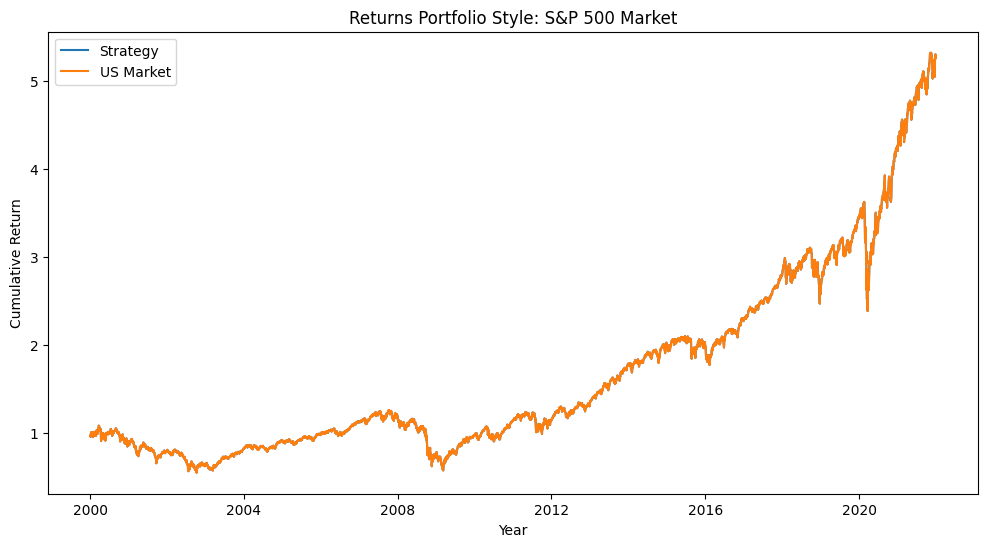

In [32]:
show_cumulative_returns(us_mkt_ret_vec, us_mkt_ret_vec, ret_port_style="S&P 500 Market", log_scale=False, show_plots=True, save=True)

In [33]:
china = load_china("20000104", "20211231")
china.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5331 entries, 20000104 to 20211230
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rf_dly  5331 non-null   float64
 1   mktrf   5331 non-null   float64
 2   VMG     5331 non-null   float64
 3   SMB     5331 non-null   float64
 4   PMO     5331 non-null   float64
dtypes: float64(5)
memory usage: 249.9 KB


In [34]:
china_mkt_ret_vec = china["mktrf"] + china["rf_dly"]
china_mkt_ret_vec.head()

date
20000104    3.05
20000105    0.31
20000106    4.12
20000107    3.75
20000110    1.99
dtype: float64

/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_mkt_rets_monthly = cum_mkt_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_strat_rets_monthly = cum_strat_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:36: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mkt_ret_vec_monthly = mkt_ret_vec_monthly.resa

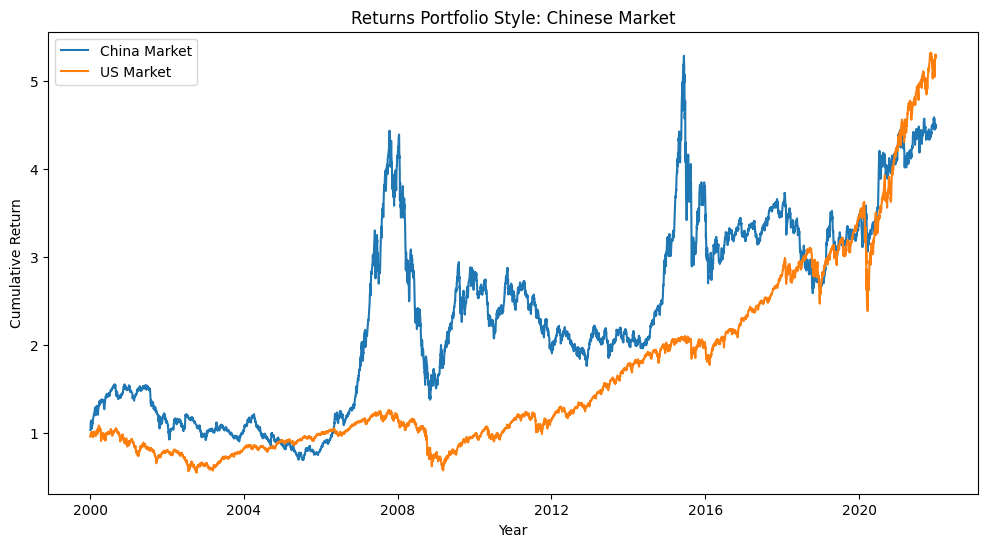

In [35]:
show_cumulative_returns(china_mkt_ret_vec, us_mkt_ret_vec, ret_port_style="Chinese Market", strategy_name="China Market", log_scale=False, show_plots=True, save=True)

In [36]:
def plot_shit(start_date, val_date):
    ff3 = load_ff3(start_date, val_date)
    china = load_china(start_date, val_date)
    us_mkt_ret_vec = ff3["Mkt-RF"] + ff3["RF"]
    china_mkt_ret_vec = china["mktrf"] + china["rf_dly"]

    show_cumulative_returns(china_mkt_ret_vec, us_mkt_ret_vec, ret_port_style="Chinese Market", strategy_name="China Market", log_scale=False, show_plots=True, save=True)

/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_mkt_rets_monthly = cum_mkt_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cum_strat_rets_monthly = cum_strat_rets.resample("M").last()
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:36: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_74938/3362708343.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mkt_ret_vec_monthly = mkt_ret_vec_monthly.resa

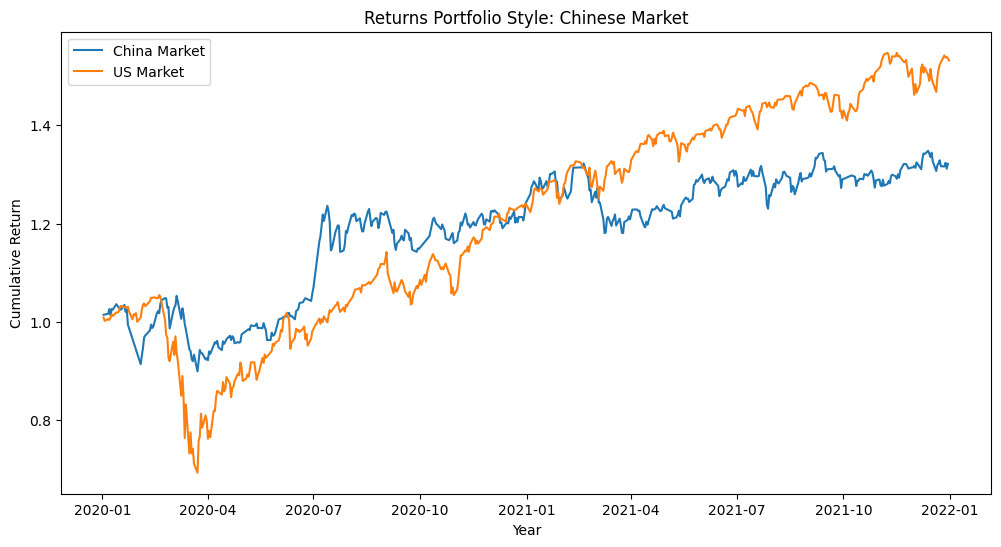

In [37]:
plot_shit("20200101", "20211231")

In [38]:
# 0.95*x to 1.25*x is a change of 